# Dataset

requirements:
- datasets 
- langraph 
- langchain-community 
- rank_bm25

In [36]:
!pip install rank_bm25

  Obtaining dependency information for rank_bm25 from https://files.pythonhosted.org/packages/2a/21/f691fb2613100a62b3fa91e9988c991e9ca5b89ea31c0d3152a3210344f9/rank_bm25-0.2.2-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from datasets import load_dataset
from langchain.docstore.document import Document

In [2]:
# Load the dataset
guest_dataset = load_dataset("agents-course/unit3-invitees", split="train")

# Convert dataset entries into Document objects
docs = [
    Document(
        page_content="\n".join([
            f"Name: {guest['name']}",
            f"Relation: {guest['relation']}",
            f"Description: {guest['description']}",
            f"Email: {guest['email']}"
        ]),
        metadata={"name": guest["name"]}
    )
    for guest in guest_dataset
]

README.md:   0%|          | 0.00/371 [00:00<?, ?B/s]

C:\dev\AI-Agent\.venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dante\.cache\huggingface\hub\datasets--agents-course--unit3-invitees. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/3.32k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3 [00:00<?, ? examples/s]

# Retriever Tool

In [3]:
from langchain_community.retrievers import BM25Retriever
from langchain.tools import Tool

In [37]:
bm25_retriever = BM25Retriever.from_documents(docs)

def extract_text(query: str) -> str:
    """Retrieves detailed information about gala guests based on their name or relation."""
    results = bm25_retriever.invoke(query)
    if results:
        return "\n\n".join([doc.page_content for doc in results[:3]])
    else:
        return "No matching guest information found."

guest_info_tool = Tool(
    name="guest_info_retriever",
    func=extract_text,
    description="Retrieves detailed information about gala guests based on their name or relation."
)

## test extract_text tool

In [38]:
extract_text("Tell me about our guest named 'Lady Ada Lovelace'.")

"Name: Ada Lovelace\nRelation: best friend\nDescription: Lady Ada Lovelace is my best friend. She is an esteemed mathematician and friend. She is renowned for her pioneering work in mathematics and computing, often celebrated as the first computer programmer due to her work on Charles Babbage's Analytical Engine.\nEmail: ada.lovelace@example.com\n\nName: Dr. Nikola Tesla\nRelation: old friend from university days\nDescription: Dr. Nikola Tesla is an old friend from your university days. He's recently patented a new wireless energy transmission system and would be delighted to discuss it with you. Just remember he's passionate about pigeons, so that might make for good small talk.\nEmail: nikola.tesla@gmail.com\n\nName: Marie Curie\nRelation: no relation\nDescription: Marie Curie was a groundbreaking physicist and chemist, famous for her research on radioactivity.\nEmail: marie.curie@example.com"

In [39]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# login with huggingface

In [9]:
# login with huggingface
from huggingface_hub import notebook_login

notebook_login()

#  Integrate the Tool with Alfred

In [11]:
# Generate the chat interface, including the tools
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-Coder-32B-Instruct"
)

In [12]:
chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [guest_info_tool]
chat_with_tools = chat.bind_tools(tools)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

C:\dev\AI-Agent\.venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dante\.cache\huggingface\hub\models--Qwen--Qwen2.5-Coder-32B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

## Generate the AgentState and Agent graph

In [13]:
# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

In [40]:
## The graph
builder = StateGraph(AgentState)

In [41]:
# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

In [42]:
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

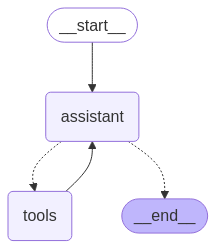

In [43]:
from IPython.display import Image, display
# Show
display(Image(alfred.get_graph(xray=True).draw_mermaid_png()))

In [44]:
messages = [HumanMessage(content="Tell me about our guest named 'Lady Ada Lovelace'.")]
messages

[HumanMessage(content="Tell me about our guest named 'Lady Ada Lovelace'.", additional_kwargs={}, response_metadata={})]

In [45]:
response = alfred.invoke({"messages": messages})

In [46]:
print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
It seems like there might be some confusion. You've listed descriptions and details for several historical figures, including Lady Ada Lovelace, but it appears you are specifically interested in learning about Ada Lovelace.

**Lady Ada Lovelace**:
- **Full Name**: Ada King, Countess of Lovelace (née Byron)
- **Birth**: December 10, 1815, London, England
- **Death**: November 27, 1852, Marylebone, London, England
- **Occupation**: Mathematician
- **Notable for**: Her work on Charles Babbage's Analytical Engine, which is often regarded as the first mechanical general-purpose computer. Lovelace not only translated an article written by Italian engineer Luigi Menabrea but also added her own annotations, which were longer than the original paper. These annotations include what is recognized as the first algorithm intended to be processed on a machine, thus making her the first computer programmer.
- **Family**: Daughter of the poet Lord Byron and Annabella Milbanke
- **

# Search tool for Alfred

In [47]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()
results = search_tool.invoke("Who's the current President of France?")
print(results)

Emmanuel Macron (born December 21, 1977, Amiens, France) is a French banker and politician who was elected president of France in 2017. Macron was the first person in the history of the Fifth Republic to win the presidency without the backing of either the Socialists or the Gaullists, and he was France's youngest head of state since Napoleon I.He was reelected in 2022, becoming the first ... Emmanuel Macron, born on December 21, 1977, is the current president of the French Republic.In office since May 14, 2017, he was re-elected on April 24, 2022 with 58.55% of the votes against his competitor Marine Le Pen. With a background in higher public service and investment banking, Macron approaches his mandate with a desire for change and innovation in various fields, including economics ... PARIS (AP) — French President Emmanuel Macron vowed Thursday to stay in office until the end of his term, due in 2027, and announced that he will name a new prime minister within days following ... The cu

# Creating a Custom Tool for Weather Information to Schedule the Fireworks

In [48]:
from langchain.tools import Tool
import random

In [50]:
import requests

def get_weather_info(location: str) -> str:
    """
    Fetches weather information for a given location.
    
    Args:
        location (str): Location in 'Europe/Madrid' format. The function is designed 
                       to work specifically with locations following this format 
                       which represents the timezone identifier for central Spain.
                       Example: 'Europe/Madrid'
    
    Returns:
        str: Formatted weather information including condition and temperature.
             Format: "Weather in {location}: {condition}, {temperature}°C"
    
    Raises:
        ValueError: If the location doesn't follow the 'Europe/Madrid' format.
        ConnectionError: If there's an issue connecting to the weather API.
        Exception: For any other unexpected errors.
    
    Notes for AI Agent Consumer:
        - This function expects locations in IANA timezone identifier format 'Europe/Madrid'
        - The weather API used (wttr.in) is free and requires no registration
        - For production use, consider implementing rate limiting to avoid API restrictions
    """
    # Validate location format
    if not location.startswith("Europe/"):
        raise ValueError("Location must be in 'Europe/Madrid' format, representing a timezone identifier")
    
    # Extract the city name from the location string
    city = location.split('/')[-1]
    
    # Using wttr.in - a free weather API that doesn't require registration
    url = f"https://wttr.in/{city}?format=j1"
    
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an exception for HTTP errors
        
        data = response.json()
        
        # Extract weather information
        current_condition = data["current_condition"][0]
        condition = current_condition["weatherDesc"][0]["value"]
        temp_c = current_condition["temp_C"]
        
        return f"Weather in {location}: {condition}, {temp_c}°C"
    
    except requests.exceptions.ConnectionError:
        raise ConnectionError("Failed to connect to the weather API. Please check your internet connection.")
    except requests.exceptions.Timeout:
        raise ConnectionError("Request to weather API timed out. Please try again later.")
    except requests.exceptions.HTTPError as e:
        raise Exception(f"HTTP error occurred: {e}")
    except ValueError as e:
        raise Exception(f"JSON parsing error: {e}")
    except Exception as e:
        raise Exception(f"An unexpected error occurred: {e}")


## Test weather tool

In [51]:
# Example usage
try:
    weather_info = get_weather_info("Europe/Madrid")
    print(weather_info)
except Exception as e:
    print(f"Error: {e}")

Weather in Europe/Madrid: Partly cloudy, 18°C


In [53]:
# Initialize the tool
weather_info_tool = Tool(
    name="get_weather_info",
    func=get_weather_info,
    description="""Fetches weather information for a given location.
    
        Args:
            location (str): Location in 'Europe/Madrid' format. The function is designed 
                           to work specifically with locations following this format 
                           which represents the timezone identifier for central Spain.
                           Example: 'Europe/Madrid'
        
        Returns:
            str: Formatted weather information including condition and temperature.
                 Format: "Weather in {location}: {condition}, {temperature}°C"
        
        Raises:
            ValueError: If the location doesn't follow the 'Europe/Madrid' format.
            ConnectionError: If there's an issue connecting to the weather API.
            Exception: For any other unexpected errors.
        
        Notes for AI Agent Consumer:
            - This function expects locations in IANA timezone identifier format 'Europe/Madrid'
            - The weather API used (wttr.in) is free and requires no registration
            - For production use, consider implementing rate limiting to avoid API restrictions"""
)

# Creating a Hub Stats Tool for Influential AI Builders

In [54]:
from langchain.tools import Tool
from huggingface_hub import list_models

In [55]:
def get_hub_stats(author: str) -> str:
    """Fetches the most downloaded model from a specific author on the Hugging Face Hub."""
    try:
        # List models from the specified author, sorted by downloads
        models = list(list_models(author=author, sort="downloads", direction=-1, limit=1))

        if models:
            model = models[0]
            return f"The most downloaded model by {author} is {model.id} with {model.downloads:,} downloads."
        else:
            return f"No models found for author {author}."
    except Exception as e:
        return f"Error fetching models for {author}: {str(e)}"

## Test the hub stats

In [57]:
get_hub_stats("facebook")

'The most downloaded model by facebook is facebook/esmfold_v1 with 19,321,664 downloads.'

In [58]:
# Initialize the tool
hub_stats_tool = Tool(
    name="get_hub_stats",
    func=get_hub_stats,
    description="Fetches the most downloaded model from a specific author on the Hugging Face Hub."
)

# Example usage
print(hub_stats_tool("facebook")) # Example: Get the most downloaded model by Facebook

C:\Users\dante\AppData\Local\Temp\ipykernel_328\1429007806.py:9: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(hub_stats_tool("facebook")) # Example: Get the most downloaded model by Facebook


The most downloaded model by facebook is facebook/esmfold_v1 with 19,321,664 downloads.


# 2nd Integrating Tools with Alfred

In [59]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

## Generate the chat interface, including the tools

In [60]:
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-Coder-32B-Instruct"
)

chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [search_tool, weather_info_tool, hub_stats_tool]
chat_with_tools = chat.bind_tools(tools)

## Generate the AgentState and Agent graph

In [61]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    return {
        "messages": [chat_with_tools.invoke(state["messages"])],
    }

## The graph

In [63]:
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
alfred = builder.compile()

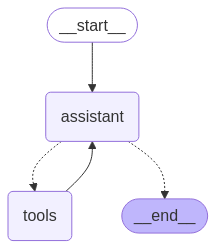

In [64]:
from IPython.display import Image, display
# Show
display(Image(alfred.get_graph(xray=True).draw_mermaid_png()))

In [69]:
messages = [HumanMessage(content="Who is Facebook and what's their most popular model?, always try get the info from tools.")]

In [70]:
response = alfred.invoke({"messages": messages})

In [71]:
print("🎩 Alfred's Response:")
print(response['messages'][-1].content)

🎩 Alfred's Response:
From the provided information, it appears that the most advanced AI models released by Meta are part of the Llama 4 series. Specifically, two models are highlighted:

1. **Llama 4 Scout**: Known for its high efficiency, it has a expansive context window of 10 million tokens, making it highly capable of handling large amounts of information. Meta has rolled out Llama 4 Scout in 40 countries across various applications such as WhatsApp, Messenger, and Instagram, powering Meta AI.

2. **Llama 4 Maverick**: A powerful model that was codistilled from Llama 4 Behemoth, it includes over 2 trillion parameters, making it one of the largest models currently available and very capable of advanced learning and inference.

However, it's important to note that these models are not individual "people" but rather advanced AI systems designed to assist with various tasks across Meta's platforms. 

If you are asking about Facebook's most popular AI application or model used for cont